In [1]:
import numpy as np
import scipy as sc
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os
from itertools import combinations
import scipy.io

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

from cvxpy import *

from skfeature.function.similarity_based import fisher_score

### Scikit-feature tutorial

In [3]:
path = os.path.join('.', '..', 'data', 'featureselection', 'lung_discrete.mat')
mat = scipy.io.loadmat(path)

X = mat['X']
n_samples, n_features = X.shape
print 'Sample size:', n_samples, n_features

y = mat['Y'][:, 0]
n_labels = y.shape[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
print "Train size:", X_train.shape, "Test size:", X_test.shape

Sample size: 73 325
Train size: (58, 325) Test size: (15, 325)


### Fisher score

In [4]:
score = fisher_score.fisher_score(X_train, y_train)
idx_fisher = fisher_score.feature_ranking(score)
print "Best features:", idx_fisher[:5]
print "Best scores:", score[:5]

Best features: [ 29  10  19  22 125]
Best scores: [ 0.77163484  0.99345583  0.52737241  0.82807028  0.77779733]


In [5]:
def get_score(X_train, X_test, y_train, y_test, clf, scorer, feature_subset):
    selected_features_train = X_train[:, feature_subset]
    selected_features_test = X_test[:, feature_subset]

    clf.fit(selected_features_train, y_train)

    y_predict = clf.predict(selected_features_test)

    return scorer(y_test, y_predict)

In [6]:
n_selected_features = 10

clf = LogisticRegression(solver='newton-cg', multi_class='multinomial')

get_score(X_train, X_test, y_train, y_test, clf, 
          accuracy_score, idx_fisher[:n_selected_features])

0.80000000000000004

### Quadratic programming approach

In [6]:
def create_opt_problem(X, y, sim, rel, verbose=False):
    """
    % Function generates matrix Q and vector b
    % which represent feature similarities and feature relevances
    %
    % Input:
    % X - [m, n] - design matrix
    % y - [m, 1] - target vector
    % sim - string - indicator of the way to compute feature similarities,
    % support values are 'correl' and 'mi'
    % rel - string - indicator of the way to compute feature significance,
    % support values are 'correl', 'mi' and 'signif'
    %
    % Output:
    % Q - [n ,n] - matrix of features similarities
    % b - [n, 1] - vector of feature relevances
    """
    
    if verbose == True:
        print "Constructing the problem..."
        print 'Similarity measure: %s, feature relevance measure: %s' % (sim, rel)
    if len(y.shape) == 1:
        y_mat = y[:, np.newaxis]
    else:
        y_mat = y[:]
        
    df = pd.DataFrame(np.hstack([X, y_mat]))
    cor = np.array(df.corr())
    
    if sim == 'correl':
        Q = cor[:-1, :-1]
    else:
        print "Wrong similarity measure"
        
    if rel == 'correl':
        b = cor[:-1, [-1]]
    elif rel == 'log-reg':
        lr = LogisticRegression()
        b = np.zeros((X.shape[1], 1))
        for i in range(X.shape[1]):
            lr.fit(X[:, [i]], y)
            y_pred = lr.predict(X[:, [i]])
            b[i] = np.corrcoef(y_pred, y)[0, 1]
        b = np.nan_to_num(b)
    else:
        print "Wrong relevance measure"
        
    if verbose == True:
        print "Problem has been constructed."
    return Q, b


def solve_opt_problem(Q, b, verbose=False):
    """
     Function solves the quadratic optimization problem stated to select
     significance and noncollinear features

     Input:
     Q - [n, n] - matrix of features similarities
     b - [n, 1] - vector of feature relevances

     Output:
     x - [n, 1] - solution of the quadratic optimization problem
    """
    
    n = Q.shape[0]
    x = Variable(n)
    
    objective = Minimize(quad_form(x, Q) - b.T*x)
    constraints = [x >= 0, norm(x, 1) <= 1]
    prob = Problem(objective, constraints)
    
    if verbose == True:
        print "Solving the QP problem..."
    
    prob.solve()
    
    if verbose == True:
        print "The problem has been solved!"
        print "Problem status:", prob.status
        print

    return np.array(x.value).flatten()
    
def quadratic_programming(X, y, sim='correl', rel='correl', verbose=False):
    Q, b = create_opt_problem(X, y, sim, rel, verbose)
    print
    qp_score = solve_opt_problem(Q, b, verbose)
    return qp_score

In [7]:
verbose = True

Q, b = create_opt_problem(X_train, y_train, sim='correl', rel='correl', verbose=True)
qp_score = solve_opt_problem(Q, b, verbose)

Constructing the problem...
Similarity measure: correl, feature relevance measure: correl
Problem has been constructed.
Solving the QP problem...
The problem has been solved!
Problem status: optimal



In [336]:
idx_qp = qp_score.argsort()[::-1]
print idx_qp[:5]

[242 231 145  33  21]


In [337]:
n_selected_features = 10

clf = LogisticRegression(solver='newton-cg', multi_class='multinomial')

get_score(X_train, X_test, y_train, y_test, clf, 
          accuracy_score, idx_qp[:n_selected_features])

0.8666666666666667

### Testing methods for generating feature relevances

In [18]:
dirname = os.path.join('.', '..', 'data')

filenames = ['COIL20.mat', 'Isolet.mat', 'USPS.mat', 'lung_discrete.mat']

qp_score_dict = dict()

for filename in filenames:
    print "Testing file:", filename
    path = os.path.join(dirname, filename)
    mat = scipy.io.loadmat(path)
    X = mat['X']
    n_samples, n_features = X.shape
    print "Data size:"
    print "-number of samples:", n_samples
    print "-number of features:", n_features
    
    y = mat['Y'][:, 0]
    n_labels = y.shape
    
    qp_score_correl = quadratic_programming(X, y, sim='correl', rel='correl', verbose=True)
    qp_score_logreg = quadratic_programming(X, y, sim='correl', rel='log-reg', verbose=True)
    qp_score_dict[filename + '_correl'] = qp_score_correl
    qp_score_dict[filename + '_logreg'] = qp_score_logreg
    print '_' * 30

Testing file: COIL20.mat
Data size:
-number of samples: 1440
-number of features: 1024
Constructing the problem...
Similarity measure: correl, feature relevance measure: correl
Problem has been constructed.

Solving the QP problem...
The problem has been solved!
Problem status: optimal

Constructing the problem...
Similarity measure: correl, feature relevance measure: log-reg
Problem has been constructed.

Solving the QP problem...
The problem has been solved!
Problem status: optimal

______________________________
Testing file: Isolet.mat
Data size:
-number of samples: 1560
-number of features: 617
Constructing the problem...
Similarity measure: correl, feature relevance measure: correl
Problem has been constructed.

Solving the QP problem...
The problem has been solved!
Problem status: optimal

Constructing the problem...
Similarity measure: correl, feature relevance measure: log-reg
Problem has been constructed.

Solving the QP problem...
The problem has been solved!
Problem status:

In [24]:
n_selected_features = range(5, 51, 5)

clf = svm.LinearSVC()

accuracy_dict = {}

for filename in filenames:
    print "File %s is processing..." % filename
    path = os.path.join(dirname, filename)
    mat = scipy.io.loadmat(path)
    X = mat['X']
    y = mat['Y'][:, 0]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
    accuracy_dict[filename + '_correl'] = []
    accuracy_dict[filename + '_logreg'] = []
    idx_qp_correl = qp_score_dict[filename + '_correl'].argsort()[::-1]
    idx_qp_logreg = qp_score_dict[filename + '_logreg'].argsort()[::-1]
    for n_f in n_selected_features:
        acc = get_score(X_train, X_test, y_train, y_test, clf, 
                      accuracy_score, idx_qp_correl[:n_f])
        accuracy_dict[filename + '_correl'].append(acc)
        
        acc = get_score(X_train, X_test, y_train, y_test, clf, 
                      accuracy_score, idx_qp_logreg[:n_f])
        accuracy_dict[filename + '_logreg'].append(acc)
        
    print "File %s has been processed" % filename
    print

File COIL20.mat is processing...
File COIL20.mat has been processed

File Isolet.mat is processing...
File Isolet.mat has been processed

File USPS.mat is processing...
File USPS.mat has been processed

File lung_discrete.mat is processing...
File lung_discrete.mat has been processed



In [36]:
def plot_accuracy(filename):
    plt.figure(figsize=(10, 5))
    plt.plot(n_selected_features, accuracy_dict[filename + '_correl'], label='correlation')
    plt.plot(n_selected_features, accuracy_dict[filename + '_logreg'], label='logreg')
    plt.legend(loc=4)
    plt.title("File: %s" % filename)
    plt.xlabel("Accuracy")
    plt.ylabel("Number of selected features")
    plt.show()

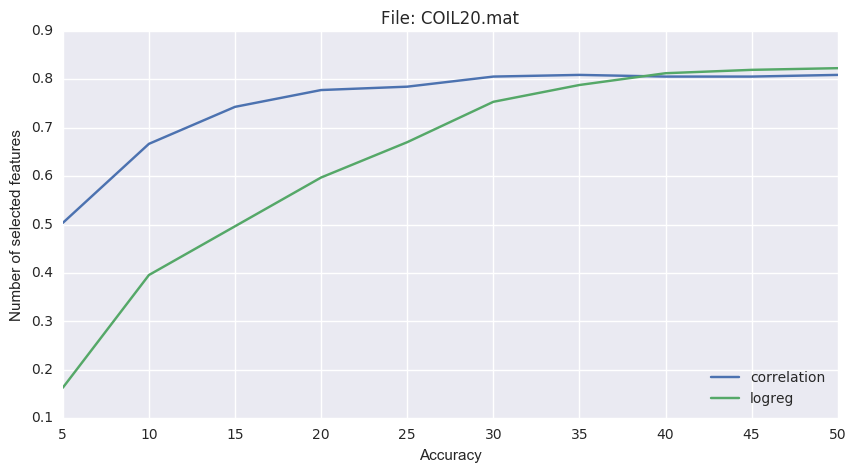

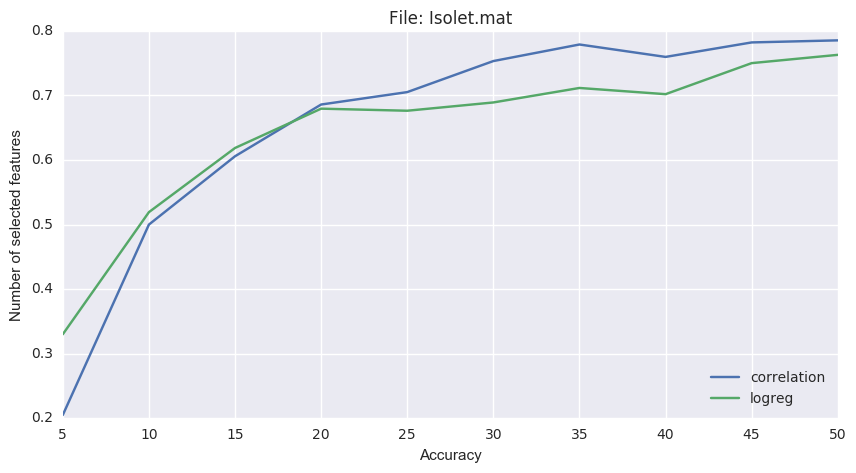

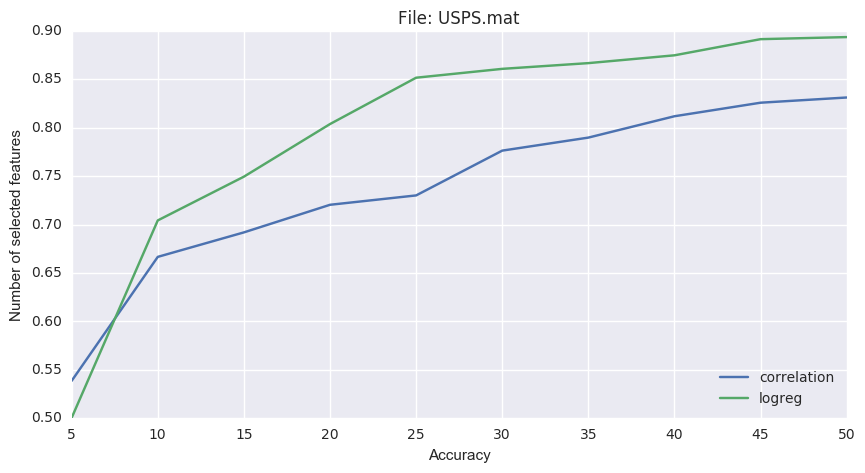

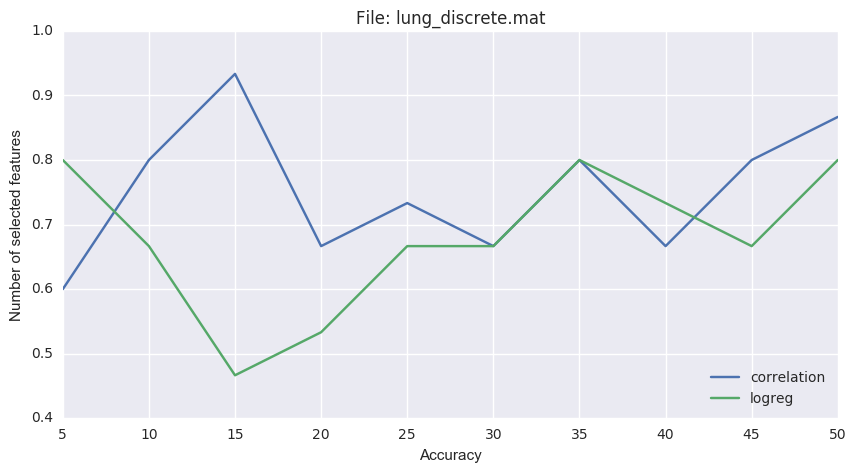

In [40]:
for filename in filenames:
    plot_accuracy(filename)

# Mixed Integer Optimization = Genetic Algorithm

In [338]:
def gen_population(n, d, k):
    population = np.zeros([n, d])
    for i, j in enumerate(np.random.choice(k, n)):
        idx = np.random.choice(d, j+1, replace=False)
        population[i, idx] = 1
    return population

def mutation(ind, k):
    d = len(ind)
    idx = np.where(np.random.choice(2, d) > 0)[0]
    ind[idx] = 1 - ind[idx]
    overload = int(ind.sum() - np.random.choice(k + 1))
    if overload > 0:
        ind[np.random.choice(np.where(ind > 0)[0], overload, replace=False)] = 0
    if ind.sum() == 0:
        ind[np.random.choice(d)] = 1
    return ind

def crossover(ind1, ind2, k):
    d = len(ind1)
    ind_cross = ind2.copy()
    idx = np.where(np.random.choice(2, d) > 0)[0]
    ind_cross[idx] = ind1[idx]    
    overload = int(ind_cross.sum() - np.random.choice(k + 1))
    if overload > 0:
        ind_cross[np.random.choice(np.where(ind_cross > 0)[0], overload, replace=False)] = 0
    if ind_cross.sum() == 0:
        ind_cross[np.random.choice(d)] = 1
    return ind_cross

def selection(population, fitness_score, n):
    init_size = population.shape[0]
    #proba = fitness_score / fitness_score.sum()
    #idx = np.random.choice(init_size, n, p = proba)
    idx = fitness_score.argsort()[::-1][:n]
    return population[idx], fitness_score[idx]

def genetic_algorithm(n_populations, n_individuals, n_features, n_selected_features):
    
    population = gen_population(n_individuals, n_features, n_selected_features)

    for i in range(n_populations):
        for idx1, idx2 in combinations(range(n_individuals), 2):
            ind_cross = crossover(population[idx1, :], population[idx2, :], n_selected_features)
            population = np.vstack([population, ind_cross])

        for idx in range(n_individuals):
            ind = mutation(population[idx, :], n_selected_features)
            population = np.vstack([population, ind])

        fitness_score = np.zeros([population.shape[0]])
        for j, ind in enumerate(population):
            X_train_selected = X_train[:, np.where(ind > 0)[0]]
            clf = LogisticRegression(max_iter=30, solver='newton-cg', 
                                     multi_class='multinomial', C=100000.)
            fitness_score[j] = np.mean(cross_val_score(clf, X_train_selected, y_train, 
                                                   scoring='accuracy'))

        population, fitness_score = selection(population, fitness_score, n_individuals)
        print "Population: %d" % (i + 1)
    best_idx = fitness_score.argmax()
    return population[best_idx].astype(bool)
    

In [341]:
dirname = os.path.join('.', '..', 'data', 'featureselection')
path = os.path.join(dirname, 'USPS.mat')
mat = scipy.io.loadmat(path)

X = mat['X'][:2000, :]
n_samples, n_features = X.shape
print n_samples, n_features

y = mat['Y'][:, 0][:2000]
n_labels = y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

2000 256


In [344]:
n_selected_features = 10

n_populations = 10
n_individuals = 10

genetic_features = genetic_algorithm(n_populations, n_individuals, 
                                           n_features, n_selected_features)

print 'Number of selected features: %d' % genetic_features.sum()

Population: 1
Population: 2
Population: 3
Population: 4
Population: 5
Population: 6
Population: 7
Population: 8
Population: 9
Population: 10
Number of selected features: 10


In [310]:
clf = LogisticRegression(solver='newton-cg', multi_class='multinomial')

get_score(X_train, X_test, y_train, y_test, clf, 
                      accuracy_score, genetic_features)

Number of selected features: 9


0.81666666666666665

In [244]:
dirname = os.path.join('.', '..', 'data')
path = os.path.join(dirname, 'Data_Cortex_Nuclear.xls')
X = pd.read_excel(path)
y = X['class']
X = X.drop(['MouseID', 'Genotype', 'Treatment', 'Behavior', 'class'], axis=1)
X = X.fillna(0)
print X.shape, y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)
clf = LogisticRegression(solver='newton-cg', multi_class='multinomial', C=1e20)

clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

accuracy_score(y_test, y_predict)

((1080, 77), (1080,))

In [302]:
dirname = os.path.join('.', '..', 'data')
path = os.path.join(dirname, 'creditcard.csv')
X = pd.read_csv(path, nrows=2000)
y = X['Class']
X = X.drop(['Amount', 'Class'], axis=1)
print X.shape, y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=35)
clf = LogisticRegression(solver='newton-cg', multi_class='multinomial', C=100000.)

clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

roc_auc_score(y_test, y_predict)

(2000, 29) (2000,)


0.49812265331664579

### 